## Artigo Original: https://arxiv.org/abs/2310.06743

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

import torch.utils.data
import math


class LayerNorm(nn.Module):
    """
    layer normalization
    Simple layer norm object optionally used with the convolutional encoder.
    """

    def __init__(self, feature_dim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones((feature_dim,)))
        self.register_parameter("gamma", self.gamma)
        self.beta = nn.Parameter(torch.zeros((feature_dim,)))
        self.register_parameter("beta", self.beta)
        self.eps = eps

    def forward(self, x):
        # x: [batch_size, embed_dim]
        # normalize for each embedding
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # output shape is the same as x
        # Type not match for self.gamma and self.beta??????????????????????
        # output: [batch_size, embed_dim]
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


def get_activation_function(activation, context_str):
    if activation == "leakyrelu":
        return nn.LeakyReLU(negative_slope=0.2)
    elif activation == "relu":
        return nn.ReLU()
    elif activation == "sigmoid":
        return nn.Sigmoid()
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'gelu':
        return nn.GELU()
    else:
        raise Exception("{} activation not recognized.".format(context_str))


class SingleFeedForwardNN(nn.Module):
    """
        Creates a single layer fully connected feed forward neural network.
        this will use non-linearity, layer normalization, dropout
        this is for the hidden layer, not the last layer of the feed forard NN
    """

    def __init__(self, input_dim,
                 output_dim,
                 dropout_rate=None,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=''):
        '''

        Args:
            input_dim (int32): the input embedding dim
            output_dim (int32): dimension of the output of the network.
            dropout_rate (scalar tensor or float): Dropout keep prob.
            activation (string): tanh or relu or leakyrelu or sigmoid
            use_layernormalize (bool): do layer normalization or not
            skip_connection (bool): do skip connection or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(SingleFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        if dropout_rate is not None:
            self.dropout = nn.Dropout(p=dropout_rate)
        else:
            self.dropout = None

        self.act = get_activation_function(activation, context_str)

        if use_layernormalize:
            # the layer normalization is only used in the hidden layer, not the last layer
            self.layernorm = nn.LayerNorm(self.output_dim)
        else:
            self.layernorm = None

        # the skip connection is only possible, if the input and out dimention is the same
        if self.input_dim == self.output_dim:
            self.skip_connection = skip_connection
        else:
            self.skip_connection = False

        self.linear = nn.Linear(self.input_dim, self.output_dim)
        nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size,..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        # Linear layer
        output = self.linear(input_tensor)
        # non-linearity
        output = self.act(output)
        # dropout
        if self.dropout is not None:
            output = self.dropout(output)

        # skip connection
        if self.skip_connection:
            output = output + input_tensor

        # layer normalization
        if self.layernorm is not None:
            output = self.layernorm(output)

        return output


class MultiLayerFeedForwardNN(nn.Module):
    """
        Creates a fully connected feed forward neural network.
        N fully connected feed forward NN, each hidden layer will use non-linearity, layer normalization, dropout
        The last layer do not have any of these
    """

    def __init__(self, input_dim,
                 output_dim,
                 num_hidden_layers=0,
                 dropout_rate=None,
                 hidden_dim=-1,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=None):
        '''

        Args:
            input_dim (int32): the input embedding dim
            num_hidden_layers (int32): number of hidden layers in the network, set to 0 for a linear network.
            output_dim (int32): dimension of the output of the network.
            dropout (scalar tensor or float): Dropout keep prob.
            hidden_dim (int32): size of the hidden layers
            activation (string): tanh or relu
            use_layernormalize (bool): do layer normalization or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(MultiLayerFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers
        self.dropout_rate = dropout_rate
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.use_layernormalize = use_layernormalize
        self.skip_connection = skip_connection
        self.context_str = context_str

        self.layers = nn.ModuleList()
        if self.num_hidden_layers <= 0:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))
        else:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.hidden_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=self.use_layernormalize,
                                                   skip_connection=self.skip_connection,
                                                   context_str=self.context_str))

            for i in range(self.num_hidden_layers - 1):
                self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                       output_dim=self.hidden_dim,
                                                       dropout_rate=self.dropout_rate,
                                                       activation=self.activation,
                                                       use_layernormalize=self.use_layernormalize,
                                                       skip_connection=self.skip_connection,
                                                       context_str=self.context_str))

            self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size, ..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        output = input_tensor
        for i in range(len(self.layers)):
            output = self.layers[i](output)

        return output


$$
\mathbf{y} = \sin(\omega_0 (\mathbf{W}\mathbf{x} + \mathbf{b}))
$$

$$
\begin{aligned}
\mathbf{h}_0 &= \mathbf{x} \\
\mathbf{h}_{\ell+1} &= \sin(\mathbf{W}_\ell \mathbf{h}_\ell + \mathbf{b}_\ell),
\quad \ell = 0, \dots, L-1 \\
\mathbf{y} &= \mathbf{W}_L \mathbf{h}_L + \mathbf{b}_L
\end{aligned}
$$

$$
\mathbf{W}_0 \sim \mathcal{U}\left(-\frac{1}{d}, \frac{1}{d}\right)
$$

$$
\mathbf{W}_\ell \sim \mathcal{U}\left(
-\frac{\sqrt{6}}{\omega_0 \sqrt{d_\ell}},
\frac{\sqrt{6}}{\omega_0 \sqrt{d_\ell}}
\right),
\quad \ell > 0
$$

$$
\text{onde } d \text{ é a dimensão da entrada, }
d_\ell \text{ é o tamanho da camada, e }
\omega_0 \text{ controla a frequência máxima aprendível.}
$$



In [ ]:
import torch
import torch.nn as nn
import numpy as np

class SineLayer(nn.Module):

    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.linear = nn.Linear(in_features, out_features, bias=bias)


        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:

                bound = 1 / self.linear.weight.size(1)
                self.linear.weight.uniform_(-bound, bound)
            else:

                bound = np.sqrt(6 / self.linear.weight.size(1)) / self.omega_0
                self.linear.weight.uniform_(-bound, bound)

    def forward(self, input):

        return torch.sin(self.omega_0 * self.linear(input))

In [ ]:
import torch
import torch.nn as nn
import numpy as np
class SirenLocationEncoder(nn.Module):
    def __init__(
        self,
        spa_embed_dim=64,
        ffn_hidden_dim=256,
        ffn_num_hidden_layers=3,
        omega_0=30,
        device="cuda",
        extent=None, interval=None, min_scale=None, max_scale=None
    ):
        super().__init__()
        self.device = device

        layers = []

        layers.append(SineLayer(2, ffn_hidden_dim, is_first=True, omega_0=omega_0))

        for _ in range(ffn_num_hidden_layers):
            layers.append(SineLayer(ffn_hidden_dim, ffn_hidden_dim, is_first=False, omega_0=omega_0))

        self.net = nn.Sequential(*layers)

        self.final_projector = nn.Linear(ffn_hidden_dim, spa_embed_dim)

    def forward(self, coords):
        if not torch.is_tensor(coords):
            coords = torch.tensor(coords, dtype=torch.float32).to(self.device)
        else:
            coords = coords.float().to(self.device)

        x = coords / 180.0

        x = self.net(x)

        out = self.final_projector(x)

        return out

In [ ]:
import pandas as pd
ESTADO = 'California'
checkins = pd.read_csv(f'/content/drive/MyDrive/Checkins_MTLPoi/separated/checkins_{ESTADO.title()}.csv')[['latitude', 'longitude', 'category','placeid']]
coords = np.stack([checkins['latitude'], checkins['longitude']], axis=1)

categories = checkins[['category']].values
placeid = checkins[['placeid']].values

In [ ]:
class SirenContrastiveModel(nn.Module):
    def __init__(self, embed_dim=64):
        super().__init__()

        self.encoder = SirenLocationEncoder(
            spa_embed_dim=128,
            ffn_hidden_dim=512,
            ffn_num_hidden_layers=4,
            omega_0=30,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

        self.projector = nn.Linear(128, embed_dim)

    def forward(self, coords):
        z = self.encoder(coords)
        z = self.projector(z)
        return torch.nn.functional.normalize(z, dim=-1)



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ContrastiveSpatialDataset(Dataset):
    def __init__(self, coords, pos_radius=0.01):

        self.coords = coords
        self.num_points = len(coords)
        self.pos_radius = pos_radius

    def __len__(self):
        return self.num_points

    def __getitem__(self, idx):
        coord_i = self.coords[idx]

        if np.random.random() > 0.5:
            label = 1.0

            noise = np.random.normal(0, self.pos_radius, size=2)
            coord_j = coord_i + noise

        else:
            label = 0.0

            rand_idx = np.random.randint(0, self.num_points)
            coord_j = self.coords[rand_idx]

        return (
            torch.tensor(coord_i, dtype=torch.float32),
            torch.tensor(coord_j, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32)
        )

In [ ]:
dataset = ContrastiveSpatialDataset(coords, pos_radius=0.01)

loader = DataLoader(
    dataset,
    batch_size=512,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True
)


print(f"Total de batches por época: {len(loader)}")

sample_i, sample_j, sample_lbl = next(iter(loader))
print("\nExemplo de saída do Loader:")
print(f"Coord A (Shape): {sample_i.shape}")
print(f"Coord B (Shape): {sample_j.shape}")
print(f"Labels (Exemplo): {sample_lbl[:5]}")

Total de batches por época: 4952

Exemplo de saída do Loader:
Coord A (Shape): torch.Size([512, 2])
Coord B (Shape): torch.Size([512, 2])
Labels (Exemplo): tensor([0., 1., 1., 0., 1.])


In [ ]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [ ]:
!pip install "sympy==1.12"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SirenContrastiveModel(embed_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def contrastive_bce(z_i, z_j, label, tau=0.1):
    sim = F.cosine_similarity(z_i, z_j)
    logits = sim / tau
    targets = label.float().to(z_i.device)
    return F.binary_cross_entropy_with_logits(logits, targets)


for epoch in range(50):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for coord_i, coord_j, label in loader:

        ci = coord_i.to(device, dtype=torch.float32, non_blocking=True)
        cj = coord_j.to(device, dtype=torch.float32, non_blocking=True)
        label = label.to(device, dtype=torch.float32, non_blocking=True)


        z_i = model(ci)
        z_j = model(cj)

        loss = contrastive_bce(z_i, z_j, label, tau=0.15)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    avg_loss = total_loss / max(n_batches, 1)
    print(f"Epoch {epoch+1:02d}: Loss = {avg_loss:.4f}")



Epoch 01: Loss = 0.7808
Epoch 02: Loss = 0.7808
Epoch 03: Loss = 0.7792
Epoch 04: Loss = 0.7791
Epoch 05: Loss = 0.7784
Epoch 06: Loss = 0.7774
Epoch 07: Loss = 0.7777
Epoch 08: Loss = 0.7773
Epoch 09: Loss = 0.7771
Epoch 10: Loss = 0.7774
Epoch 11: Loss = 0.7767
Epoch 12: Loss = 0.7766
Epoch 13: Loss = 0.7763
Epoch 14: Loss = 0.7769
Epoch 15: Loss = 0.7769
Epoch 16: Loss = 0.7767
Epoch 17: Loss = 0.7764
Epoch 18: Loss = 0.7765
Epoch 19: Loss = 0.7765
Epoch 20: Loss = 0.7759
Epoch 21: Loss = 0.7760
Epoch 22: Loss = 0.7759
Epoch 23: Loss = 0.7761
Epoch 24: Loss = 0.7760
Epoch 25: Loss = 0.7763
Epoch 26: Loss = 0.7760
Epoch 27: Loss = 0.7759
Epoch 28: Loss = 0.7763
Epoch 29: Loss = 0.7761
Epoch 30: Loss = 0.7759
Epoch 31: Loss = 0.7753
Epoch 32: Loss = 0.7753
Epoch 33: Loss = 0.7762
Epoch 34: Loss = 0.7756
Epoch 35: Loss = 0.7755
Epoch 36: Loss = 0.7759
Epoch 37: Loss = 0.7760
Epoch 38: Loss = 0.7754
Epoch 39: Loss = 0.7756
Epoch 40: Loss = 0.7754
Epoch 41: Loss = 0.7759
Epoch 42: Loss =

In [ ]:
loc_embeds = model(torch.Tensor(coords))

loc_embeds

tensor([[-0.0956, -0.0643, -0.0313,  ..., -0.1460, -0.0259,  0.1806],
        [-0.0956, -0.0643, -0.0313,  ..., -0.1460, -0.0259,  0.1806],
        [-0.0956, -0.0643, -0.0313,  ..., -0.1460, -0.0259,  0.1806],
        ...,
        [-0.0438,  0.0484,  0.1253,  ...,  0.0441, -0.1281, -0.0351],
        [-0.0633,  0.0791,  0.1727,  ..., -0.0987,  0.2156,  0.0813],
        [-0.0451, -0.2262, -0.1112,  ..., -0.2420, -0.0650, -0.1285]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
loc_embeds = loc_embeds.detach().cpu().numpy()

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import pandas as pd
import numpy as np
import torch
import os

folder_path = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/siren/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

emb_np = loc_embeds
n_embeds = emb_np.shape[1]
embed_cols = [f"{i}" for i in range(n_embeds)]

placeid_arr = np.asarray(placeid).reshape(-1)
category_arr = np.asarray(categories).reshape(-1)

if emb_np.shape[0] != len(placeid_arr):
    raise ValueError(f"loc_embeds tem {emb_np.shape[0]} linhas, "
                     f"mas placeid tem {len(placeid_arr)} elementos.")

df_location_embeddings = pd.DataFrame(emb_np, columns=embed_cols)
df_location_embeddings.insert(0, "placeid", placeid_arr.astype(str))
df_location_embeddings["category"] = category_arr.astype(str)

print("df_location_embeddings (check-in level):", df_location_embeddings.shape)

out_path = f"/content/drive/MyDrive/MTL_POI_Novo/data/output/{ESTADO.lower()}/location_encoder_embeddings-siren.csv"
df_location_embeddings.to_csv(out_path, index=False)
print("Salvo:", out_path)

df_location_embeddings.head()


df_location_embeddings (check-in level): (2535573, 66)
Salvo: /content/drive/MyDrive/MTL_POI_Novo/data/output/california/location_encoder_embeddings-siren.csv


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,29835,-0.095596,-0.064266,-0.031345,0.07466,0.05894,-0.060537,-0.011772,0.075507,0.088925,...,-0.065344,0.090911,-0.053402,-0.046442,0.071975,0.170412,-0.145975,-0.025923,0.180609,Community
1,29835,-0.095596,-0.064266,-0.031345,0.07466,0.05894,-0.060537,-0.011772,0.075507,0.088925,...,-0.065344,0.090911,-0.053402,-0.046442,0.071975,0.170412,-0.145975,-0.025923,0.180609,Community
2,29835,-0.095596,-0.064266,-0.031345,0.07466,0.05894,-0.060537,-0.011772,0.075507,0.088925,...,-0.065344,0.090911,-0.053402,-0.046442,0.071975,0.170412,-0.145975,-0.025923,0.180609,Community
3,29835,-0.095596,-0.064266,-0.031345,0.07466,0.05894,-0.060537,-0.011772,0.075507,0.088925,...,-0.065344,0.090911,-0.053402,-0.046442,0.071975,0.170412,-0.145975,-0.025923,0.180609,Community
4,29835,-0.095596,-0.064266,-0.031345,0.07466,0.05894,-0.060537,-0.011772,0.075507,0.088925,...,-0.065344,0.090911,-0.053402,-0.046442,0.071975,0.170412,-0.145975,-0.025923,0.180609,Community


In [ ]:
df = pd.read_csv(f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/siren/location_encoder_embeddings-{ESTADO.lower()}.csv")
placeids = df["placeid"].astype(str).tolist()
E = df[[c for c in df.columns if c.isnumeric()]].to_numpy(dtype=np.float32)

torch.save({
    "embeddings": torch.from_numpy(E),
    "placeids": placeids
}, f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/siren/poi_embeddings_location-{ESTADO.lower()}.pt")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/siren/location_encoder_embeddings-california.csv'

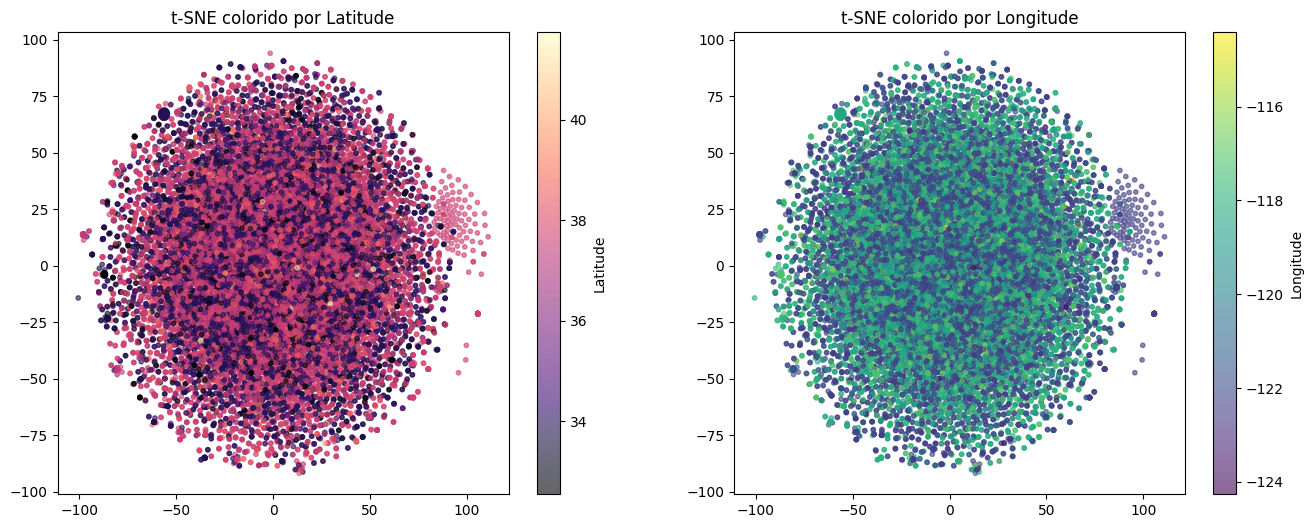

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

n_samples = 15000
indices = np.random.choice(len(loc_embeds), n_samples, replace=False)

subset_embeds = loc_embeds[indices]
subset_coords = coords[indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeds_2d = tsne.fit_transform(subset_embeds)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sc1 = ax[0].scatter(embeds_2d[:, 0], embeds_2d[:, 1],
                    c=subset_coords[:, 0], cmap='magma', s=10, alpha=0.6)
ax[0].set_title("t-SNE colorido por Latitude")
plt.colorbar(sc1, ax=ax[0], label='Latitude')

sc2 = ax[1].scatter(embeds_2d[:, 0], embeds_2d[:, 1],
                    c=subset_coords[:, 1], cmap='viridis', s=10, alpha=0.6)
ax[1].set_title("t-SNE colorido por Longitude")
plt.colorbar(sc2, ax=ax[1], label='Longitude')

plt.show()